In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [22]:
df=pd.read_csv('data/005930.KS_1.csv')
df=df.set_index(pd.to_datetime(df.Date)) # Date를 날짜로 지정해서 index로
df=df[['Open','High','Low','Close','Volume','Adj Close']]
df

,Open,High,Low,Close,Volume,Adj Close
Date,,,,,,
2022-05-17,66600.0,67900.0,66600.0,67600.0,15680447,65934.203125
2022-05-18,68300.0,68700.0,67600.0,68100.0,16486319,66421.882813
2022-05-19,66500.0,67600.0,66500.0,67500.0,17073727,65836.664063
2022-05-20,67800.0,68400.0,67700.0,68000.0,12109671,66324.343750
2022-05-23,68800.0,68800.0,67600.0,67900.0,13684088,66226.812500
...,...,...,...,...,...,...
2023-05-11,64700.0,65100.0,64200.0,64200.0,11648905,64200.000000
2023-05-12,63700.0,64600.0,63600.0,64100.0,8693913,64100.000000
2023-05-15,64100.0,64600.0,63900.0,64500.0,8172021,64500.000000


날짜를 인덱스로 그래야 x축으로 해서 그래프 그리기 좋다 날짜는 문자 나머지는 숫자이므로 섞이지 않도록 날짜 인덱스를 텍스트가 아닌 날짜로 변환 그래야 크기에 따라 날짜로 조정이 가능(머신러닝은 Tense나 numpy 배열을 쓰는데 그안에 문자가 들어간적이 없다.)

In [23]:
df.isnull().sum() # null 값을 찾기 쓰고자 나는 데이터에 null 값이 있다면 Tense로 변환하지 못한다(오류가 뜸), -같은걸로 되어있을수있다.

Open         0
High         0
Low          0
Close        0
Volume       0
Adj Close    0
dtype: int64

In [24]:
df.loc[df['Volume']==0] # 거래량이 있나 없나 찾기

,Open,High,Low,Close,Volume,Adj Close
Date,,,,,,


In [25]:
df['Volume']=df['Volume'].replace(0,np.nan) #0을 nan으로 바꾸기
df.isnull().sum()

Open         0
High         0
Low          0
Close        0
Volume       0
Adj Close    0
dtype: int64

In [26]:
df=df.dropna() # 행에 na 들어있는건 다 지운다
df.isnull().sum()

Open         0
High         0
Low          0
Close        0
Volume       0
Adj Close    0
dtype: int64

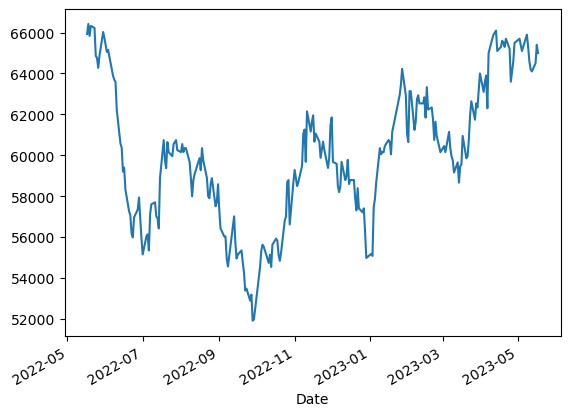

In [29]:
pig=df['Adj Close'].plot()

In [32]:
seq_length=7
batch_size=100

df=df[::-1]

train_size=int(df.shape[0]*0.8) # df.shape[0] -> len(df) 으로 가능
train_set=df[0:train_size]
test_set=df[train_size-seq_length:]
print(train_set.shape, test_set.shape)


(199, 6) (57, 6)


In [33]:
# 데이터 스케일링
# Input scale
scaler_x=MinMaxScaler()
scaler_x.fit(train_set.iloc[:, :-1])

train_set.iloc[:, :-1]=scaler_x.transform(train_set.iloc[:,:-1]) # 첫번째부터 맨 마지막 전까지
test_set.iloc[:, :-1]=scaler_x.transform(test_set.iloc[:,:-1])

# Output scale
scaler_y=MinMaxScaler()
scaler_y.fit(train_set.iloc[:, [-1]])

train_set.iloc[:, -1]=scaler_y.transform(train_set.iloc[:,[-1]])
test_set.iloc[:, -1]=scaler_y.transform(test_set.iloc[:,[-1]])

C:\Users\admin\AppData\Local\Temp\ipykernel_9996\586763740.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_set.iloc[:, :-1]=scaler_x.transform(train_set.iloc[:,:-1]) # 첫번째부터 맨 마지막 전까지
C:\Users\admin\AppData\Local\Temp\ipykernel_9996\586763740.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set.iloc[:, :-1]=scaler_x.transform(test_set.iloc[:,:-1])
C:\Users\admin\AppData\Local\Temp\ipykernel_9996\586763740.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

In [34]:
import torch
import torch.nn as nn
import torch.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

In [35]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(125)
if torch.cuda.is_available() :
    torch.cuda.manual_seed_all(125)

In [39]:
def build_dataset(time_series, seq_length):
    dataX=[]
    dataY=[]

    for i in range(0, len(time_series)-seq_length):
        _x=time_series[i:i+seq_length, :]
        _y=time_series[i+seq_length, [-1]]
        # print(_x, _y)
        dataX.append(_x)
        dataY.append(_y)
    return np.array(dataX), np.array(dataY)    

In [40]:
trainX, trainY = build_dataset(np.array(train_set), seq_length)
testX, testY= build_dataset(np.array(test_set), seq_length)

In [41]:
trainX_tensor=torch.FloatTensor(trainX)
trainY_tensor=torch.FloatTensor(trainY)

testX_tensor=torch.FloatTensor(testX)
testY_tensor=torch.FloatTensor(testY)

train_dataset=TensorDataset(trainX_tensor, trainY_tensor)
train_dataload=DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

test_dataset=TensorDataset(testX_tensor, testY_tensor)
test_dataload=DataLoader(test_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

In [42]:
data_dim=6 #입력데이터 갯수
hidden_dim=10
output_dim=1
learning_rate=0.01
n_epochs=100

In [43]:
class Net(nn.Module):
    def __init__(self, input_dim, hidden_dim, seq_len, output_dim, layers):
        super(Net, self).__init__()
        self.hidden_dim=hidden_dim
        self.seq_len=seq_len
        self.output_dim=output_dim
        self.layers=layers

        self.lstm=nn.LSTM(input_dim, hidden_dim, num_layers=layers, batch_first=True)
        self.fc=nn.Linear(hidden_dim, output_dim, bias=True)

    # 학습 초기화를 위한 함수
    def reset_hidden_state(self):
        self.hidden=(
            torch.zeros(self.layers, self.seq_len, self.hidden_dim),
            torch.zeros(self.layers, self.seq_len, self.hidden_dim)
        )
    def forward(self, x):
        x, _status=self.lstm(x)
        x=self.fc(x[:, -1])
        return x

In [50]:
def train_model(model, train_df, num_epochs=None, lr=None, verbos=10, patience=10):
    criterion=nn.MSELoss().to(device)
    optimizer=optim.Adam(model.parameters(),lr=learning_rate)
    nb_epochs=num_epochs

    # epoch마다 loss 저장
    train_hist=np.zeros(n_epochs)

    for epoch in range(nb_epochs+1):
        avg_cost=0
        total_batch=len(train_df)

        for batch_idx, samples in enumerate(train_df):
            x_train, y_train = samples

            model.reset_hidden_state()
            outputs=model(x_train)
            loss=criterion(outputs, y_train)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            avg_cost+=loss/total_batch
        
        train_hist[epoch]=avg_cost

        if epoch % verbos == 0:
            print('Epoch:', '%04d' %(epoch), 'train loss', '{:.4f}'.format(avg_cost))

        if (epoch % patience ==0) & (epoch !=0):
            if train_hist[epoch-patience] < train_hist[epoch]:
                print('\n Earay Stopping')
                break

    return model.eval(), train_hist        

Epoch: 0000 train loss 0.0671
Epoch: 0020 train loss 0.0076
Epoch: 0040 train loss 0.0043
Epoch: 0060 train loss 0.0032
Epoch: 0080 train loss 0.0033

 Earay Stopping


<function matplotlib.pyplot.show(close=None, block=None)>

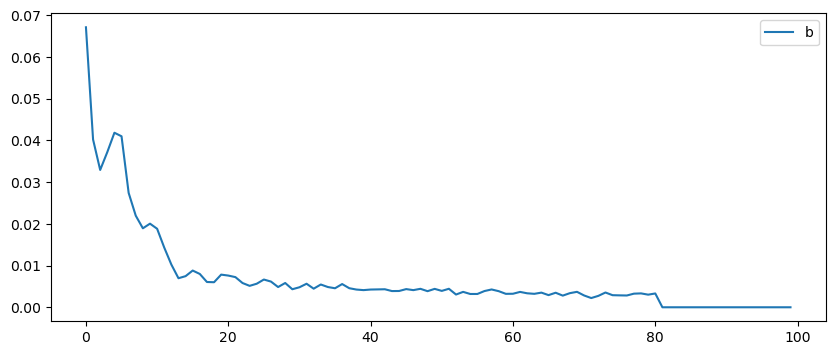

In [51]:
net=Net(data_dim, hidden_dim, seq_length, output_dim, 1).to(device)
model, train_hist = train_model(net, train_dataload, num_epochs=n_epochs, lr=learning_rate, verbos=20, patience=20)

fig=plt.figure(figsize=(10, 4))
plt.plot(train_hist, label='Training loss')
plt.legend('best')
plt.show

In [52]:
PATH='data/lstm_005930_KS.pth'
torch.save(model.state_dict(), PATH)

model=Net(data_dim, hidden_dim, seq_length, output_dim, 1).to(device)
model.load_state_dict(torch.load(PATH), strict=False)
model.eval()

Net(
  (lstm): LSTM(6, 10, batch_first=True)
  (fc): Linear(in_features=10, out_features=1, bias=True)
)

In [60]:
with torch.no_grad():
    pred=[]
    for pr in range(len(testX_tensor)):
        model.reset_hidden_state()

        predicted=model(torch.unsqueeze(testX_tensor[pr],0))
        predicted=torch.flatten(predicted).item()
        pred.append(predicted)

    pred_inverse=scaler_y.inverse_transform(np.array(pred).reshape(-1,1))
    testY_inverse=scaler_y.inverse_transform(testY_tensor)

def MAE(true, pred):
    return np.mean(np.abs(true-pred))

print('MAE SCORE:', MAE(pred_inverse, testY_inverse))

MAE SCORE: 877.5243551078622


Text(0.5, 1.0, 'Prediction result')

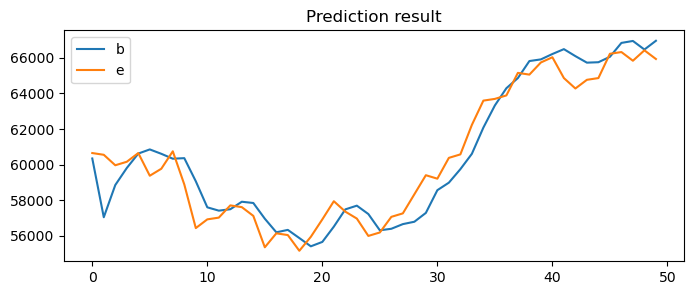

In [61]:
fig=plt.figure(figsize=(8,3))
plt.plot(np.arange(len(pred_inverse)), pred_inverse, label='pred')
plt.plot(np.arange(len(testY_inverse)), testY_inverse, label='True')
plt.legend('best')
plt.title('Prediction result')

In [62]:
class GRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, seq_len, output_dim, layers):
        super(GRU, self).__init__()
        self.num_classes = output_dim
        self.num_layers=layers
        self.input_size= input_dim
        self.hidden_size=hidden_dim
        self.seq_len=seq_len
        

        self.gru=nn.GRU(input_size=input_dim, hidden_size=hidden_dim, num_layers=layers, batch_first=True)
        self.fc_1=nn.Linear(hidden_dim, 128)
        self.fc = nn.Linear(128, output_dim)
        self.relu= nn.ReLU()

    def forward(self, x):
        h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        output, (hn) = self.gru(x, (h_0))
        hn = hn.view(-1, self.hidden_size)
        out = self.relu(hn)
        out = self.fc_1(out)
        out = self.relu(out)
        out = self.fc(out)
        return out

In [71]:
def train_model(model, train_df, num_epochs=None, lr=None, verbos=10, patience=10):
    criterion=nn.MSELoss().to(device)
    optimizer=optim.Adam(model.parameters(),lr=learning_rate)
    nb_epochs=num_epochs

    # epoch마다 loss 저장
    train_hist=np.zeros(n_epochs)

    for epoch in range(nb_epochs):
        avg_cost=0
        total_batch=len(train_df)

        for batch_idx, samples in enumerate(train_df):
            x_train, y_train = samples

            # model.reset_hidden_state()
            outputs=model(x_train)
            loss=criterion(outputs, y_train)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            avg_cost+=loss/total_batch
        
        train_hist[epoch]=avg_cost

        if epoch % verbos == 0:
            print('Epoch:', '%04d' %(epoch), 'train loss', '{:.4f}'.format(avg_cost))

        if (epoch % patience ==0) & (epoch !=0):
            if train_hist[epoch-patience] < train_hist[epoch]:
                print('\n Earay Stopping')
                break

    return model.eval(), train_hist        

Epoch: 0000 train loss 0.2414
Epoch: 0020 train loss 0.0084
Epoch: 0040 train loss 0.0035
Epoch: 0060 train loss 0.0027
Epoch: 0080 train loss 0.0026


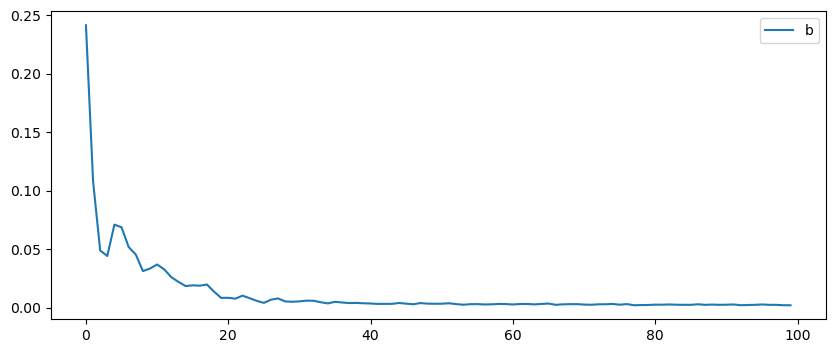

In [72]:
net=GRU(data_dim, hidden_dim, seq_length, output_dim, 1).to(device)
model, train_hist = train_model(net, train_dataload, num_epochs=n_epochs, lr=learning_rate, verbos=20, patience=20)

fig=plt.figure(figsize=(10, 4))
plt.plot(train_hist, label='Training loss')
plt.legend('best')
plt.show()

In [73]:
PATH_GRU='data/GRU_stock.pth'
torch.save(model.state_dict(), PATH_GRU)

model=GRU(data_dim, hidden_dim, seq_length, output_dim, 1).to(device)
model.load_state_dict(torch.load(PATH_GRU), strict=False)
model.eval()

GRU(
  (gru): GRU(6, 10, batch_first=True)
  (fc_1): Linear(in_features=10, out_features=128, bias=True)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

In [74]:
with torch.no_grad():
    pred=[]
    for pr in range(len(testX_tensor)):
        # model.reset_hidden_state()

        predicted=model(torch.unsqueeze(testX_tensor[pr],0))
        predicted=torch.flatten(predicted).item()
        pred.append(predicted)

    pred_inverse=scaler_y.inverse_transform(np.array(pred).reshape(-1,1))
    testY_inverse=scaler_y.inverse_transform(testY_tensor)

def MAE(true, pred):
    return np.mean(np.abs(true-pred))

print('MAE SCORE:', MAE(pred_inverse, testY_inverse))

MAE SCORE: 860.9711450476572


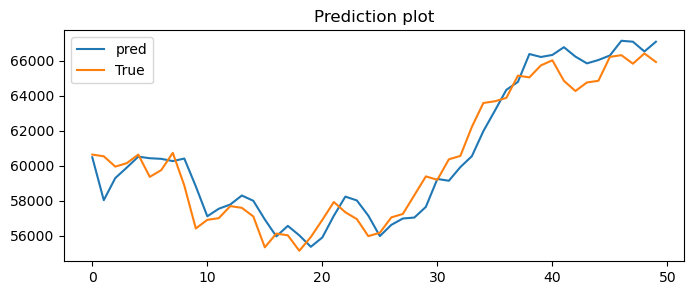

In [75]:
fig=plt.figure(figsize=(8,3))
plt.plot(np.arange(len(pred_inverse)), pred_inverse, label='pred')
plt.plot(np.arange(len(testY_inverse)), testY_inverse, label='True')
plt.title('Prediction plot')
plt.legend()
plt.show()